In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../mnist-data/", one_hot=True)

Extracting ../mnist-data/train-images-idx3-ubyte.gz
Extracting ../mnist-data/train-labels-idx1-ubyte.gz
Extracting ../mnist-data/t10k-images-idx3-ubyte.gz
Extracting ../mnist-data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.images.shape

(55000, 784)

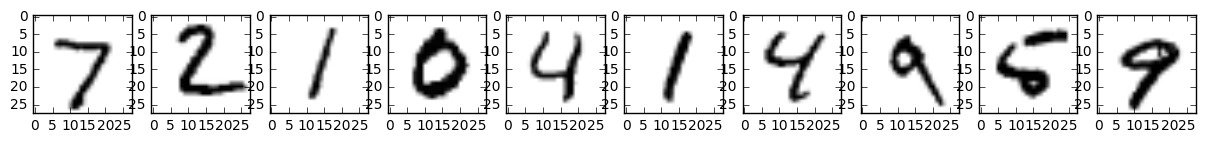

In [5]:
plt.figure(figsize=(15,5))
for i in list(range(10)):
    plt.subplot(1, 10, i+1)
    pixels = mnist.test.images[i]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')
plt.show()

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.layers import Dropout, Flatten, Reshape, merge
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

Using TensorFlow backend.


In [7]:
from  functools import reduce

def print_layers(model):
    for l in model.layers:
        print(l.name, l.output_shape, [reduce(lambda x, y: x*y, w.shape) for w in l.get_weights()])

In [8]:
def BNConv(nb_filter, nb_row, nb_col, subsample=(1, 1), border_mode="same"):
    def f(input):
        conv = Convolution2D(nb_filter=nb_filter, nb_row=nb_row, nb_col=nb_col, subsample=subsample,
                      border_mode=border_mode, activation="relu", init="he_normal")(input)
        return BatchNormalization()(conv)
    return f

In [9]:
def inception_naive_module(m=1):
    def f(input):

        # Tower A
        conv_a = BNConv(32*m, 1, 1)(input)

        # Tower B
        conv_b = BNConv(32*m, 3, 3)(input)

        # Tower C
        conv_c = BNConv(16*m, 5, 5)(input)

        # Tower D
        pool_d = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), border_mode="same")(input)
        
        return merge([conv_a, conv_b, conv_c, pool_d], mode='concat', concat_axis=3)

    return f

In [10]:
def inception_dimred_module(m=1):
    def f(input):

        # Tower A
        conv_a = BNConv(32*m, 1, 1)(input)

        # Tower B
        conv_b = BNConv(16*m, 1, 1)(input)
        conv_b = BNConv(32*m, 3, 3)(conv_b)

        # Tower C
        conv_c = BNConv(4*m, 1, 1)(input)
        conv_c = BNConv(16*m, 5, 5)(conv_c)

        # Tower D
        # max pooling followed by compression 
        pool_d = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), border_mode="same")(input)
        conv_d = BNConv(16*m, 1, 1)(pool_d)
        
        return merge([conv_a, conv_b, conv_c, conv_d], mode='concat', concat_axis=3)

    return f

In [11]:
def inception(version='v2'):
    #select inception module
    if version=='v2' :
        inception_module = inception_dimred_module
    else: 
        # naive version, big filter banks, 
        # stacking = too many params!
        inception_module = inception_naive_module
        
    
    #input in the right shape, tensorflow ordered
    _in = Input(shape=(784,))
    reshape_1 = Reshape((28,28,1))(_in)
    
    # go to 32 channels
    conv_0 = BNConv(32, 3, 3)(reshape_1)
    conv_0 = BNConv(32, 3, 3)(conv_0)
    pool_0 = MaxPooling2D((2, 2))(conv_0)
    
    # apply inception network (input: 14x14x32, output channels:96)
    module_1 = inception_module()(pool_0)
    
    # pool to 7x7x96
    pool_1 = MaxPooling2D((2, 2))(module_1)

    # apply inception network (input: 7x7x96, output channels:192)
    module_2 = inception_module(m=2)(pool_1)
    
    # pool to: 1x1x96 and flatten
    x = AveragePooling2D((7, 7))(module_2)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    # dense layer and normalization
    fc = Dense(128, activation='relu')(x)
    fc = BatchNormalization()(fc)
    
    _out = Dense(10, activation='softmax')(fc)
    model = Model(_in, _out)
    
    return model

### Inception mini model

In [12]:
# loosely adapted from https://arxiv.org/pdf/1409.4842v1.pdf

model = inception()
print_layers(model)

input_1 (None, 784) []
reshape_1 (None, 28, 28, 1) []
convolution2d_1 (None, 28, 28, 32) [288, 32]
batchnormalization_1 (None, 28, 28, 32) [32, 32, 32, 32]
convolution2d_2 (None, 28, 28, 32) [9216, 32]
batchnormalization_2 (None, 28, 28, 32) [32, 32, 32, 32]
maxpooling2d_1 (None, 14, 14, 32) []
convolution2d_4 (None, 14, 14, 16) [512, 16]
convolution2d_6 (None, 14, 14, 4) [128, 4]
batchnormalization_4 (None, 14, 14, 16) [16, 16, 16, 16]
batchnormalization_6 (None, 14, 14, 4) [4, 4, 4, 4]
maxpooling2d_2 (None, 14, 14, 32) []
convolution2d_3 (None, 14, 14, 32) [1024, 32]
convolution2d_5 (None, 14, 14, 32) [4608, 32]
convolution2d_7 (None, 14, 14, 16) [1600, 16]
convolution2d_8 (None, 14, 14, 16) [512, 16]
batchnormalization_3 (None, 14, 14, 32) [32, 32, 32, 32]
batchnormalization_5 (None, 14, 14, 32) [32, 32, 32, 32]
batchnormalization_7 (None, 14, 14, 16) [16, 16, 16, 16]
batchnormalization_8 (None, 14, 14, 16) [16, 16, 16, 16]
merge_1 (None, 14, 14, 96) []
maxpooling2d_3 (None, 7, 7, 9

In [13]:
# https://arxiv.org/pdf/1409.4842v1.pdf

from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=["accuracy"])

model.fit(mnist.train.images, mnist.train.labels,
          batch_size=128, nb_epoch=10, verbose=1, 
          validation_data=(mnist.test.images, mnist.test.labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/10
55000/55000 [==============================] - 301s - loss: 0.1732 - acc: 0.9461 - val_loss: 0.9663 - val_acc: 0.7623
Epoch 2/10
55000/55000 [==============================] - 300s - loss: 0.0661 - acc: 0.9795 - val_loss: 0.2275 - val_acc: 0.9370
Epoch 3/10
55000/55000 [==============================] - 294s - loss: 0.0521 - acc: 0.9837 - val_loss: 0.0562 - val_acc: 0.9833
Epoch 4/10
55000/55000 [==============================] - 296s - loss: 0.0464 - acc: 0.9859 - val_loss: 0.0484 - val_acc: 0.9838
Epoch 5/10
55000/55000 [==============================] - 42906s - loss: 0.0395 - acc: 0.9878 - val_loss: 0.0454 - val_acc: 0.9863
Epoch 6/10
55000/55000 [==============================] - 299s - loss: 0.0371 - acc: 0.9885 - val_loss: 0.0543 - val_acc: 0.9833
Epoch 7/10
55000/55000 [==============================] - 284s - loss: 0.0330 - acc: 0.9893 - val_loss: 0.0354 - val_acc: 0.9898
Epoch 8/10
55000/55000 [=====================

In [14]:
model.fit(mnist.train.images, mnist.train.labels,
          batch_size=128, nb_epoch=10, verbose=1, 
          validation_data=(mnist.test.images, mnist.test.labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/10
55000/55000 [==============================] - 279s - loss: 0.0295 - acc: 0.9903 - val_loss: 0.0424 - val_acc: 0.9873
Epoch 2/10
55000/55000 [==============================] - 287s - loss: 0.0282 - acc: 0.9908 - val_loss: 0.0631 - val_acc: 0.9802
Epoch 3/10
55000/55000 [==============================] - 289s - loss: 0.0239 - acc: 0.9923 - val_loss: 0.0351 - val_acc: 0.9889
Epoch 4/10
55000/55000 [==============================] - 290s - loss: 0.0236 - acc: 0.9929 - val_loss: 0.0702 - val_acc: 0.9805
Epoch 5/10
55000/55000 [==============================] - 294s - loss: 0.0228 - acc: 0.9930 - val_loss: 0.0308 - val_acc: 0.9907
Epoch 6/10
55000/55000 [==============================] - 299s - loss: 0.0232 - acc: 0.9928 - val_loss: 0.0807 - val_acc: 0.9772
Epoch 7/10
55000/55000 [==============================] - 297s - loss: 0.0222 - acc: 0.9931 - val_loss: 0.0494 - val_acc: 0.9880
Epoch 8/10
55000/55000 [=======================

In [ ]:
model.fit(mnist.train.images, mnist.train.labels,
          batch_size=128, nb_epoch=10, verbose=1, 
          validation_data=(mnist.test.images, mnist.test.labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/10
55000/55000 [==============================] - 300s - loss: 0.0144 - acc: 0.9955 - val_loss: 0.0558 - val_acc: 0.9876
Epoch 2/10
55000/55000 [==============================] - 303s - loss: 0.0120 - acc: 0.9962 - val_loss: 0.0382 - val_acc: 0.9879
Epoch 3/10
55000/55000 [==============================] - 299s - loss: 0.0122 - acc: 0.9960 - val_loss: 0.0600 - val_acc: 0.9847
Epoch 4/10
55000/55000 [==============================] - 15912s - loss: 0.0120 - acc: 0.9961 - val_loss: 0.0401 - val_acc: 0.9902
Epoch 5/10
55000/55000 [==============================] - 20254s - loss: 0.0108 - acc: 0.9965 - val_loss: 0.0293 - val_acc: 0.9931
Epoch 6/10
55000/55000 [==============================] - 217578s - loss: 0.0101 - acc: 0.9965 - val_loss: 0.0325 - val_acc: 0.9925
Epoch 7/10
55000/55000 [==============================] - 38210s - loss: 0.0113 - acc: 0.9963 - val_loss: 0.0379 - val_acc: 0.9901
Epoch 8/10
21632/55000 [==========>...